# Stage 5 — Model Optimization & Evaluation (Clustering)

**Dataset:** `clean_realestate.csv` (real-estate listings)

This notebook performs hyperparameter tuning (KMeans, Agglomerative, DBSCAN), multi‑metric ranking, stability via bootstrapping, and visual/statistical comparisons — adapted to this dataset’s schema.

In [5]:
import numpy as np
import pandas as pd
import ast
import itertools
from collections import defaultdict
from datetime import datetime

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import wilcoxon
import numpy.random as npr
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
npr.seed(RANDOM_SEED)
print('Imports complete')

Imports complete


## Data Ingest & Preprocessing (tailored)
- Uses **`ad_url`** as a unique ID for exporting labels.
- Parses **`description_embedding`** (length 768) into numeric feature columns `emb_0..emb_767`.
- Encodes categoricals (`apartment_style`, `neighborhood`, `city`, `city_group`) with one‑hot.
- Derives simple time features from `published_at` (month, dayofweek).
- Drops non‑feature text columns (`address`, raw `description_embedding`, raw `published_at`, `type`).
- Scales all numeric features for distance‑based clustering.

In [6]:
CSV_PATH = '/Users/nadavcohen/Desktop/Data_Science_Project_Yad2/Data/clean_realestate.csv'
ID_COL = 'ad_url'
CATEGORICAL_COLS = ['apartment_style','neighborhood','city','city_group']
DROP_COLS = ['address','type']  # non-feature text/constant columns
DATE_COL = 'published_at'
EMB_COL = 'description_embedding'

df = pd.read_csv(CSV_PATH)
assert EMB_COL in df.columns, f'Missing {EMB_COL} column'
print('Loaded:', df.shape)
ids = df[ID_COL].values if ID_COL in df.columns else np.arange(len(df))

# --- Parse 768-d embedding column into numeric matrix ---
def parse_embedding_col(series):
    return np.vstack(series.apply(lambda s: np.array(ast.literal_eval(s), dtype=float)))
emb = parse_embedding_col(df[EMB_COL])
emb_df = pd.DataFrame(emb, columns=[f'emb_{i}' for i in range(emb.shape[1])])
print('Embedding shape:', emb_df.shape)

# --- Time features from published_at ---
if DATE_COL in df.columns:
    dt = pd.to_datetime(df[DATE_COL], errors='coerce')
    df['pub_month'] = dt.dt.month
    df['pub_dayofweek'] = dt.dt.dayofweek

# --- One-hot encode selected categoricals ---
for c in CATEGORICAL_COLS:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown').astype(str)
cat_df = pd.get_dummies(df[[c for c in CATEGORICAL_COLS if c in df.columns]], drop_first=False)
print('Categorical one-hot shape:', cat_df.shape)

# --- Numeric/boolean features ---
num_bool_cols = []
for c in df.columns:
    if c in [ID_COL, EMB_COL, DATE_COL] + DROP_COLS + CATEGORICAL_COLS:
        continue
    if pd.api.types.is_bool_dtype(df[c]) or pd.api.types.is_numeric_dtype(df[c]):
        num_bool_cols.append(c)
num_df = df[num_bool_cols].copy()
# Minimal imputation
for c in num_df.columns:
    if num_df[c].isna().any():
        if pd.api.types.is_bool_dtype(num_df[c]):
            num_df[c] = num_df[c].fillna(False)
        else:
            num_df[c] = num_df[c].fillna(num_df[c].median())
print('Numeric/bool feature shape:', num_df.shape)

# --- Assemble feature matrix ---
X_df = pd.concat([num_df.reset_index(drop=True), cat_df.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)
print('Final feature frame:', X_df.shape)
X = X_df.values

# --- Scale ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled X:', X_scaled.shape)

Loaded: (6324, 25)
Embedding shape: (6324, 768)
Categorical one-hot shape: (6324, 382)
Numeric/bool feature shape: (6324, 18)
Final feature frame: (6324, 1168)
Scaled X: (6324, 1168)


In [7]:
def silhouette_score_safe(X, labels):
    mask = labels != -1
    if mask.sum() <= 2 or len(np.unique(labels[mask])) < 2:
        return np.nan
    return silhouette_score(X[mask], labels[mask], metric='euclidean')

def calinski_harabasz_safe(X, labels):
    mask = labels != -1
    if mask.sum() <= 2 or len(np.unique(labels[mask])) < 2:
        return np.nan
    return calinski_harabasz_score(X[mask], labels[mask])

def davies_bouldin_safe(X, labels):
    mask = labels != -1
    if mask.sum() <= 2 or len(np.unique(labels[mask])) < 2:
        return np.nan
    return davies_bouldin_score(X[mask], labels[mask])

def evaluate_labels(X, labels):
    n_clusters = len([l for l in np.unique(labels) if l != -1])
    noise_ratio = float(np.mean(labels == -1))
    return {
        'silhouette': silhouette_score_safe(X, labels),
        'calinski_harabasz': calinski_harabasz_safe(X, labels),
        'davies_bouldin': davies_bouldin_safe(X, labels),
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
    }

def rank_and_score(df, weights=None):
    df = df.copy()
    if weights is None:
        weights = {'silhouette': 0.5, 'calinski_harabasz': 0.3, 'davies_bouldin': 0.2}
    df['silhouette_filled'] = df['silhouette'].fillna(-1e9)
    df['calinski_harabasz_filled'] = df['calinski_harabasz'].fillna(-1e9)
    df['davies_bouldin_filled'] = df['davies_bouldin'].fillna(1e9)
    df['rank_sil'] = (-df['silhouette_filled']).rank(method='min')
    df['rank_ch']  = (-df['calinski_harabasz_filled']).rank(method='min')
    df['rank_db']  = (df['davies_bouldin_filled']).rank(method='min')
    for c in ['rank_sil','rank_ch','rank_db']:
        df[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min() + 1e-12)
    df['weighted_score'] = (
        (1 - df['rank_sil']) * weights['silhouette'] +
        (1 - df['rank_ch'])  * weights['calinski_harabasz'] +
        (1 - df['rank_db'])  * weights['davies_bouldin']
    )
    return df.drop(columns=['silhouette_filled','calinski_harabasz_filled','davies_bouldin_filled'])

def pca_2d(X):
    p = PCA(n_components=2, random_state=RANDOM_SEED)
    return p.fit_transform(X)

def plot_scatter_2d(emb2d, labels, title):
    plt.figure()
    plt.scatter(emb2d[:,0], emb2d[:,1], c=labels, s=6)
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.show()

def plot_silhouette_values(X, labels, title):
    from sklearn.metrics import silhouette_samples
    mask = labels != -1
    if mask.sum() <= 2 or len(np.unique(labels[mask])) < 2:
        print('Silhouette plot skipped (invalid clustering).')
        return
    sample_sil = silhouette_samples(X[mask], labels[mask])
    order = np.argsort(labels[mask])
    plt.figure()
    plt.plot(sample_sil[order])
    plt.title(title + f' | mean silhouette={sample_sil.mean():.3f}')
    plt.xlabel('Sorted samples (by label)')
    plt.ylabel('Silhouette value')
    plt.show()


In [8]:
KMEANS_GRID = {
    'n_clusters': list(range(2, 16)),
    'n_init': [10],
    'max_iter': [300],
}
AGGLO_GRID = {
    'n_clusters': list(range(2, 16)),
    'linkage': ['ward', 'complete', 'average'],
    'metric': ['euclidean'],
}
DBSCAN_GRID = {
    'min_samples': [5, 10, 20],
    'eps_quantiles': [0.94, 0.96, 0.98, 0.99],
}
print('Grids ready')

Grids ready


In [9]:
from sklearn.metrics import pairwise_distances

def search_kmeans(X):
    rows = []
    for k in KMEANS_GRID['n_clusters']:
        for n_init in KMEANS_GRID['n_init']:
            for max_iter in KMEANS_GRID['max_iter']:
                km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=RANDOM_SEED)
                labels = km.fit_predict(X)
                met = evaluate_labels(X, labels)
                rows.append({'family':'kmeans','params':{'n_clusters':k,'n_init':n_init,'max_iter':max_iter}, **met})
    return pd.DataFrame(rows)

def search_agglomerative(X):
    rows = []
    for k in AGGLO_GRID['n_clusters']:
        for linkage in AGGLO_GRID['linkage']:
            for metric in AGGLO_GRID['metric']:
                kwargs = {'n_clusters': k, 'linkage': linkage}
                try:
                    ag = AgglomerativeClustering(metric=metric, **kwargs)
                except TypeError:
                    ag = AgglomerativeClustering(affinity=metric, **kwargs)
                labels = ag.fit_predict(X)
                met = evaluate_labels(X, labels)
                rows.append({'family':'agglomerative','params':{'n_clusters':k,'linkage':linkage,'metric':metric}, **met})
    return pd.DataFrame(rows)

def search_dbscan(X):
    rows = []
    for min_samples in DBSCAN_GRID['min_samples']:
        neigh = NearestNeighbors(n_neighbors=min_samples)
        neigh.fit(X)
        dists, _ = neigh.kneighbors(X)
        kth = np.sort(dists[:, -1])
        candidates = [np.quantile(kth, q) for q in DBSCAN_GRID['eps_quantiles']]
        for eps in candidates:
            db = DBSCAN(eps=float(eps), min_samples=int(min_samples))
            labels = db.fit_predict(X)
            met = evaluate_labels(X, labels)
            rows.append({'family':'dbscan','params':{'eps':float(eps),'min_samples':int(min_samples)}, **met})
    return pd.DataFrame(rows)


In [10]:
df_kmeans = search_kmeans(X_scaled)
df_agglom = search_agglomerative(X_scaled)
df_dbscan = search_dbscan(X_scaled)
df_all = pd.concat([df_kmeans, df_agglom, df_dbscan], ignore_index=True)
df_all = rank_and_score(df_all)
display_cols = ['family','params','silhouette','calinski_harabasz','davies_bouldin','n_clusters','noise_ratio','weighted_score']
df_all_sorted = df_all.sort_values('weighted_score', ascending=False)[display_cols]
df_all_sorted.head(10)

,family,params,silhouette,calinski_harabasz,davies_bouldin,n_clusters,noise_ratio,weighted_score
16,agglomerative,"{'n_clusters': 2, 'linkage': 'average', 'metri...",0.622469,12.226013,0.275014,2,0.0,0.813793
19,agglomerative,"{'n_clusters': 3, 'linkage': 'average', 'metri...",0.620438,12.217581,0.275351,3,0.0,0.791379
22,agglomerative,"{'n_clusters': 4, 'linkage': 'average', 'metri...",0.619614,12.222231,0.275409,4,0.0,0.775862
25,agglomerative,"{'n_clusters': 5, 'linkage': 'average', 'metri...",0.618619,12.203204,0.275934,5,0.0,0.753448
15,agglomerative,"{'n_clusters': 2, 'linkage': 'complete', 'metr...",0.620178,15.103394,2.551298,2,0.0,0.737931
28,agglomerative,"{'n_clusters': 6, 'linkage': 'average', 'metri...",0.617200,12.178226,0.276423,6,0.0,0.731034
31,agglomerative,"{'n_clusters': 7, 'linkage': 'average', 'metri...",0.616337,12.165421,0.276622,7,0.0,0.708621
18,agglomerative,"{'n_clusters': 3, 'linkage': 'complete', 'metr...",0.615046,13.439603,1.972077,3,0.0,0.687931
21,agglomerative,"{'n_clusters': 4, 'linkage': 'complete', 'metr...",0.614864,12.863621,1.567328,4,0.0,0.677586
24,agglomerative,"{'n_clusters': 5, 'linkage': 'complete', 'metr...",0.614701,12.569202,1.288563,5,0.0,0.677586


In [11]:
best_overall = df_all.sort_values('weighted_score', ascending=False).iloc[0].to_dict()
best_by_family = (df_all.sort_values('weighted_score', ascending=False).groupby('family', as_index=False).head(1))
print('Best overall:', best_overall['family'], best_overall['params'], 'score=', round(best_overall['weighted_score'],4))
print('\nBest by family:')
print(best_by_family[['family','params','weighted_score']])
df_all_sorted.to_csv('stage5_search_results_realestate.csv', index=False)
print('Saved stage5_search_results_realestate.csv')

Best overall: agglomerative {'n_clusters': 2, 'linkage': 'average', 'metric': 'euclidean'} score= 0.8138

Best by family:
           family                                             params  \
16  agglomerative  {'n_clusters': 2, 'linkage': 'average', 'metri...   
0          kmeans   {'n_clusters': 2, 'n_init': 10, 'max_iter': 300}   
57         dbscan      {'eps': 47.342706727071224, 'min_samples': 5}   

    weighted_score  
16        0.813793  
0         0.620690  
57        0.525862  
Saved stage5_search_results_realestate.csv


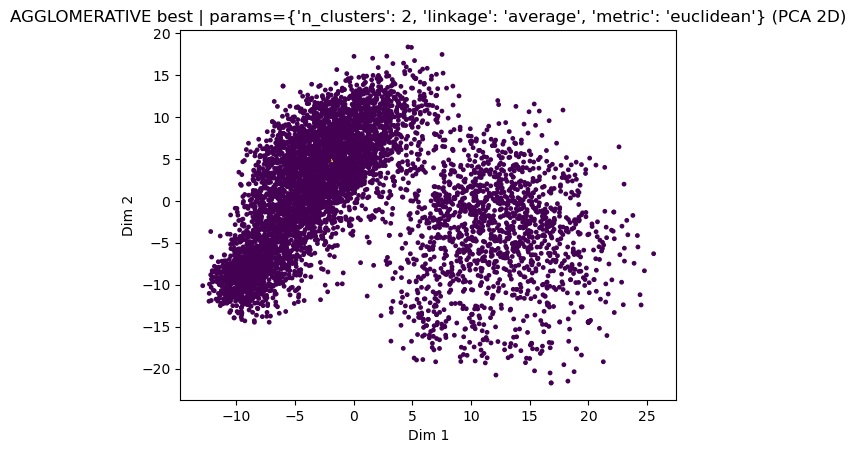

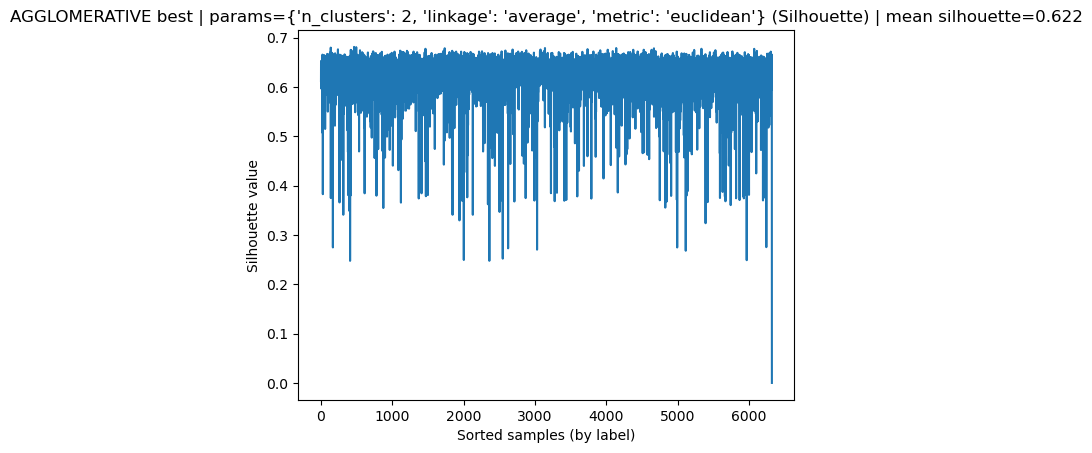

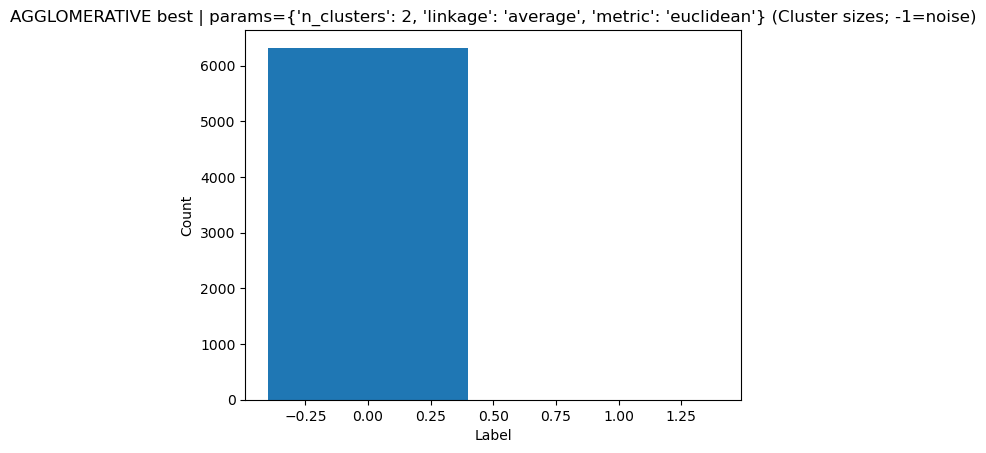

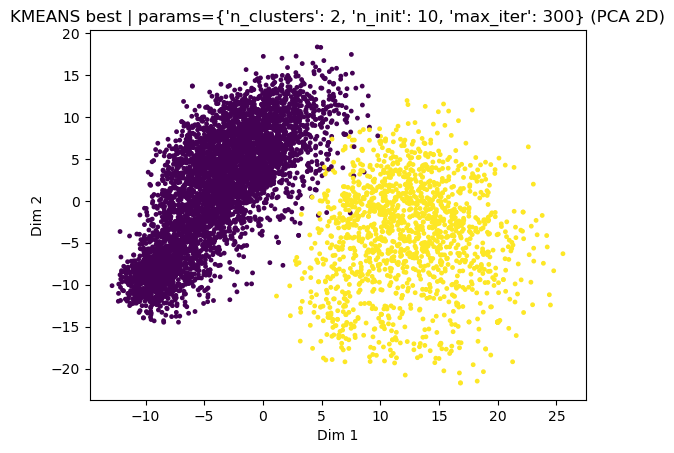

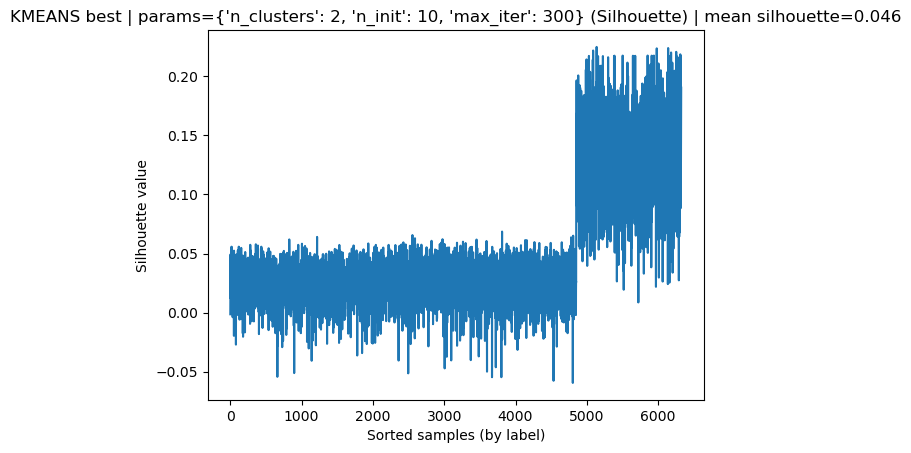

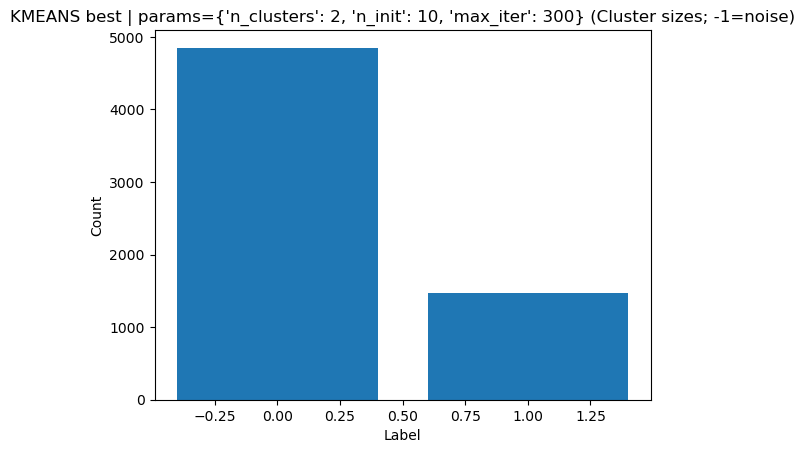

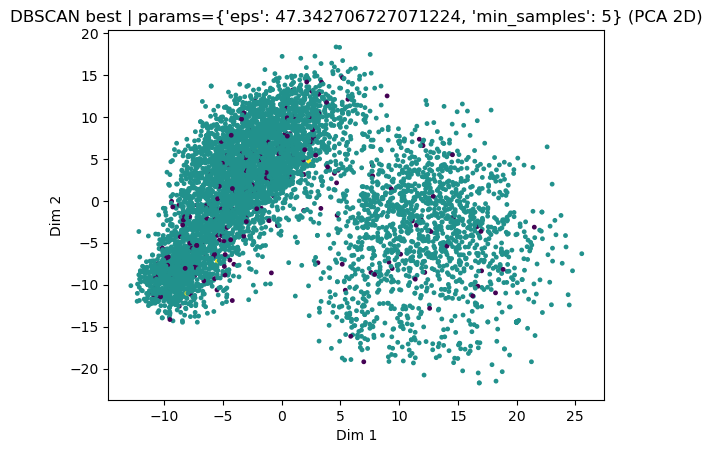

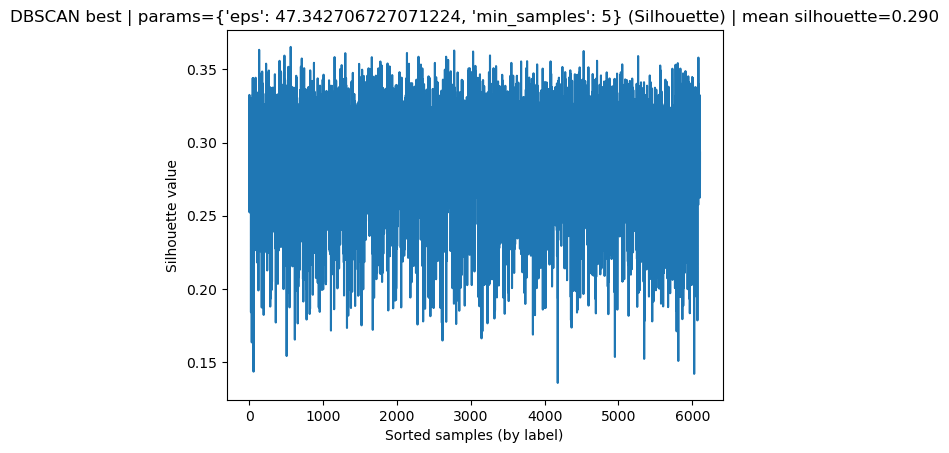

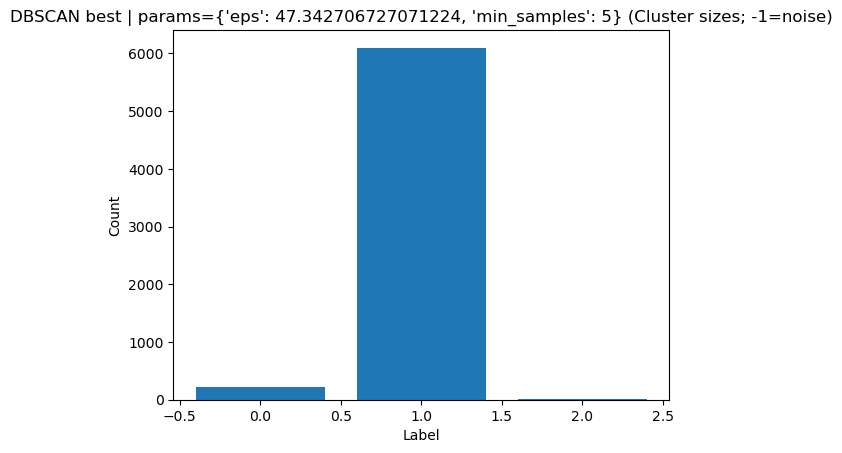

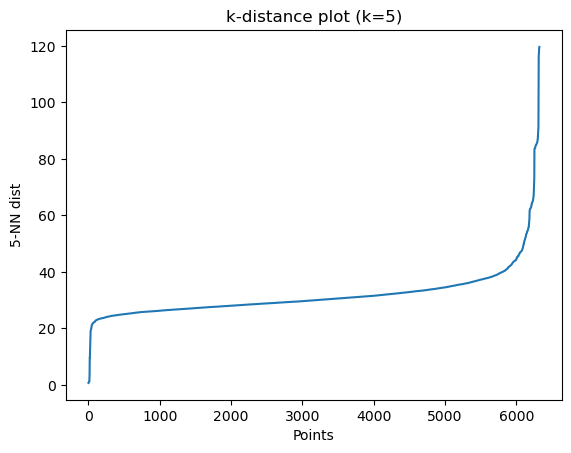

In [12]:
emb2d = pca_2d(X_scaled)
for _, row in best_by_family.iterrows():
    fam = row['family']
    p = row['params']
    if fam == 'kmeans':
        model = KMeans(random_state=RANDOM_SEED, **p)
    elif fam == 'agglomerative':
        try:
            model = AgglomerativeClustering(**p)
        except TypeError:
            p2 = p.copy()
            metric = p2.pop('metric','euclidean')
            p2['affinity'] = metric
            model = AgglomerativeClustering(**p2)
    else:
        model = DBSCAN(**p)
    labels = model.fit_predict(X_scaled)
    title = f"{fam.upper()} best | params={p}"
    plot_scatter_2d(emb2d, labels, title + ' (PCA 2D)')
    plot_silhouette_values(X_scaled, labels, title + ' (Silhouette)')
    vals, counts = np.unique(labels, return_counts=True)
    plt.figure(); plt.bar(range(len(vals)), counts)
    plt.title(title + ' (Cluster sizes; -1=noise)'); plt.xlabel('Label'); plt.ylabel('Count'); plt.show()

row_db = best_by_family[best_by_family['family']=='dbscan']
if not row_db.empty:
    ms = int(row_db.iloc[0]['params']['min_samples'])
    neigh = NearestNeighbors(n_neighbors=ms).fit(X_scaled)
    dists,_ = neigh.kneighbors(X_scaled)
    kth = np.sort(dists[:, -1])
    plt.figure(); plt.plot(kth); plt.title(f'k-distance plot (k={ms})'); plt.xlabel('Points'); plt.ylabel(f'{ms}-NN dist'); plt.show()

In [13]:
def bootstrap_stability(model_factory, X, B=10, sample_frac=0.8):
    labels_list, index_list = [], []
    n = X.shape[0]
    for b in range(B):
        idx = np.random.choice(n, size=int(sample_frac*n), replace=True)
        Xb = X[idx]
        labels = model_factory().fit_predict(Xb)
        labels_list.append(labels); index_list.append(idx)
    aris = []
    for i in range(B-1):
        inter, ia, ib = np.intersect1d(index_list[i], index_list[i+1], return_indices=True)
        if len(inter) < 5: continue
        a = labels_list[i][ia]; b = labels_list[i+1][ib]
        if len(np.unique(a))<2 or len(np.unique(b))<2: continue
        aris.append(adjusted_rand_score(a, b))
    return aris

stability_rows = []
for _, row in best_by_family.iterrows():
    fam = row['family']; p = row['params']
    def fac():
        if fam=='kmeans': return KMeans(random_state=np.random.randint(0,10000), **p)
        elif fam=='agglomerative':
            try: return AgglomerativeClustering(**p)
            except TypeError:
                p2=p.copy(); metric=p2.pop('metric','euclidean'); p2['affinity']=metric; return AgglomerativeClustering(**p2)
        else: return DBSCAN(**p)
    aris = bootstrap_stability(fac, X_scaled, B=12, sample_frac=0.8)
    stability_rows.append({'family':fam, 'params':p, 'mean_ARI': np.mean(aris) if len(aris)>0 else np.nan, 'n_pairs':len(aris)})
pd.DataFrame(stability_rows).sort_values('mean_ARI', ascending=False)

,family,params,mean_ARI,n_pairs
0,agglomerative,"{'n_clusters': 2, 'linkage': 'average', 'metri...",1.000000,3
1,kmeans,"{'n_clusters': 2, 'n_init': 10, 'max_iter': 300}",0.998973,11
2,dbscan,"{'eps': 47.342706727071224, 'min_samples': 5}",0.946034,11


In [14]:
def bootstrap_metric_distribution(model_factory, X, B=20, sample_frac=0.8):
    vals = []
    n = X.shape[0]
    for b in range(B):
        idx = np.random.choice(n, size=int(sample_frac*n), replace=True)
        labels = model_factory().fit_predict(X[idx])
        vals.append(silhouette_score_safe(X[idx], labels))
    return np.array(vals, dtype=float)

distros = {}
for _, row in best_by_family.iterrows():
    fam=row['family']; p=row['params']
    def fac():
        if fam=='kmeans': return KMeans(random_state=np.random.randint(0,10000), **p)
        elif fam=='agglomerative':
            try: return AgglomerativeClustering(**p)
            except TypeError:
                p2=p.copy(); metric=p2.pop('metric','euclidean'); p2['affinity']=metric; return AgglomerativeClustering(**p2)
        else: return DBSCAN(**p)
    distros[fam]=bootstrap_metric_distribution(fac, X_scaled, B=20, sample_frac=0.8)

pairs=list(itertools.combinations(list(distros.keys()),2))
pvals=[]
for a,b in pairs:
    av=distros[a][~np.isnan(distros[a])]; bv=distros[b][~np.isnan(distros[b])]
    n=min(len(av),len(bv))
    p=np.nan if n<5 else wilcoxon(av[:n], bv[:n], zero_method='wilcox', alternative='two-sided', mode='auto')[1]
    pvals.append(p)
order=np.argsort(pvals); m=len(pvals); holm=[np.nan]*m
for r,idx in enumerate(order):
    holm[idx]=np.nan if np.isnan(pvals[idx]) else min((m-r)*pvals[idx],1.0)
rows=[{'pair':f'{a} vs {b}','wilcoxon_p':p,'holm_adj_p':padj} for (a,b),p,padj in zip(pairs,pvals,holm)]
pd.DataFrame(rows)

,pair,wilcoxon_p,holm_adj_p
0,agglomerative vs kmeans,0.000002,0.000006
1,agglomerative vs dbscan,0.000002,0.000004
2,kmeans vs dbscan,0.000002,0.000002


In [15]:
OUTDIR='stage5_outputs_realestate'; os.makedirs(OUTDIR, exist_ok=True)
for _, row in best_by_family.iterrows():
    fam=row['family']; p=row['params']
    if fam=='kmeans': model=KMeans(random_state=RANDOM_SEED, **p)
    elif fam=='agglomerative':
        try: model=AgglomerativeClustering(**p)
        except TypeError:
            p2=p.copy(); metric=p2.pop('metric','euclidean'); p2['affinity']=metric; model=AgglomerativeClustering(**p2)
    else: model=DBSCAN(**p)
    labels=model.fit_predict(X_scaled)
    pd.DataFrame({'id': ids, 'label': labels}).to_csv(os.path.join(OUTDIR, f'labels_{fam}.csv'), index=False)
    print('Saved', os.path.join(OUTDIR, f'labels_{fam}.csv'))

NameError: name 'os' is not defined